In [162]:
!pip install phonetics -q

In [52]:
!pip install librosa matplotlib torchinfo symspellpy fuzzy -q

In [125]:
# imports
import whisper
import IPython
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from torchinfo import summary
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
import torch
from symspellpy.symspellpy import SymSpell, Verbosity
import queue
import threading
import time
import numpy as np
import sounddevice as sd
from scipy import signal
from IPython.display import display, clear_output
import phonetics

In [5]:
# convert whisper to pt
hf_model_name = "yezarniko/pharmacy-whisper-en"
output_file = "pharmacy-whisper-en.pt"

# Load HF model
model = WhisperForConditionalGeneration.from_pretrained(hf_model_name)
processor = WhisperProcessor.from_pretrained(hf_model_name)

# # torch.save(model.state_dict(), output_file)

In [51]:
# load whisper model
# model_name = "small"
# model = whisper.load_model(model_name)

In [52]:
# summary(model)

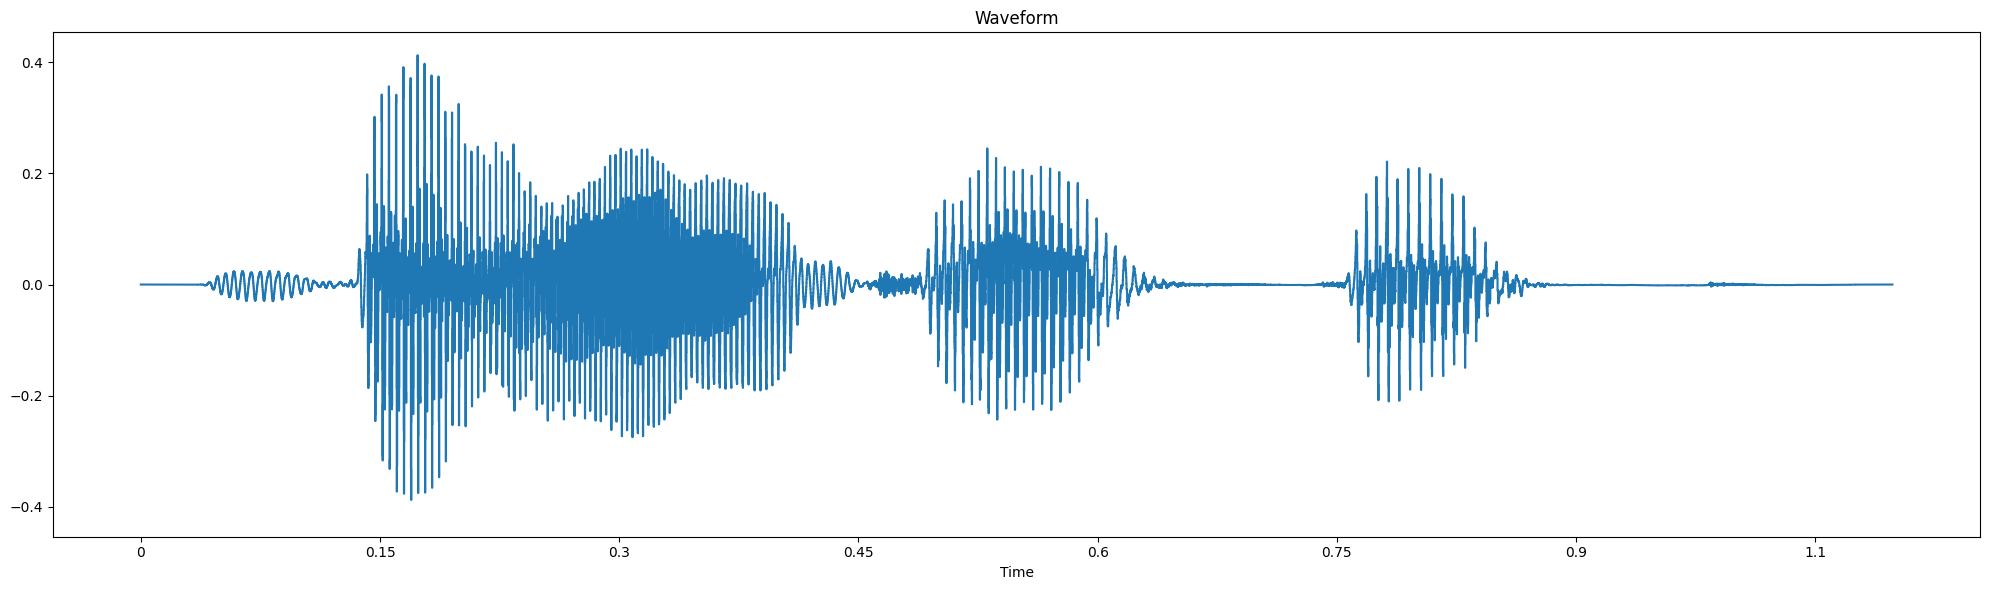

In [3]:
audio_path = "samples/biogestic.wav"
audio = whisper.load_audio(audio_path)
audio = whisper.pad_or_trim(audio)

# plot
samples, sample_rate = librosa.load(audio_path, sr=None)
plt.figure(figsize=(20, 6))
librosa.display.waveshow(samples, sr=sample_rate)
plt.title("Waveform")
plt.tight_layout()
plt.show()
IPython.display.Audio(audio_path)


In [6]:
# make log-Mel spectrogram 
# mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device); mel_np = mel.detach().numpy()
inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
mel = inputs["input_features"][0]
mel_np = mel.detach().numpy()
pd.DataFrame(mel_np)

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.770724,-0.770724,-0.770724,-0.479991,-0.235818,-0.395754,-0.175716,-0.154995,0.020500,0.013761,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
1,-0.770724,-0.770724,-0.770724,-0.621733,-0.175108,-0.102003,-0.156530,0.006767,0.047065,-0.037590,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
2,-0.770724,-0.770724,-0.770724,-0.610428,0.130459,0.252792,0.284824,0.374807,0.437348,0.482688,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
3,-0.770724,-0.770724,-0.770724,-0.567371,0.286954,0.597318,0.694953,0.730287,0.741964,0.733089,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
4,-0.770724,-0.770724,-0.770724,-0.560374,0.344939,0.680054,0.766466,0.766886,0.759584,0.728221,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
76,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
77,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724
78,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,...,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724,-0.770724


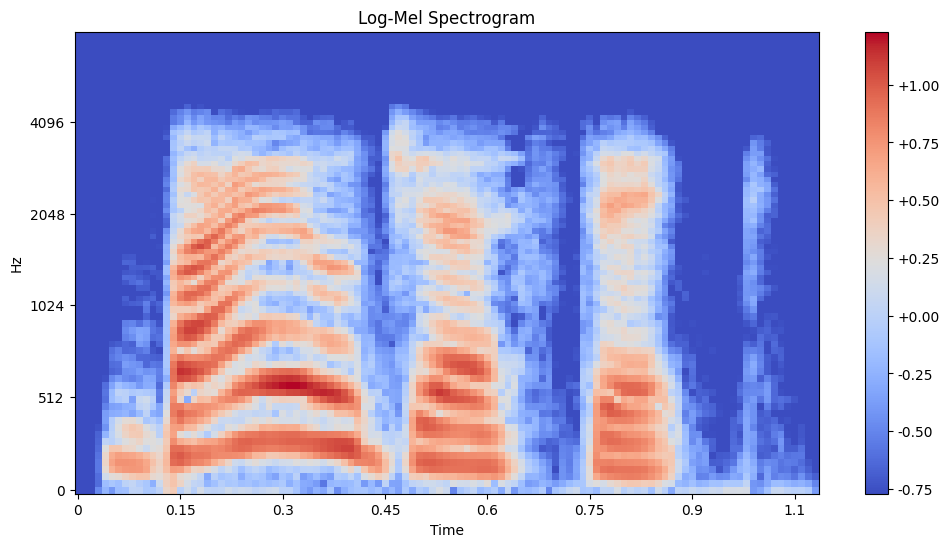

In [7]:
sr = 16000 # sampling rate of whisper 16kHz
hop_length = 160; 
crop_second = samples.shape[0]/sample_rate;
end_frame = int(crop_second * sr / hop_length)
mel_np = mel_np[:, :end_frame]

plt.figure(figsize=(12, 6))
librosa.display.specshow(
    mel_np,
    x_axis="time",
    y_axis="mel",
    sr=sr,
    hop_length=hop_length,
)
plt.title("Log-Mel Spectrogram")
plt.colorbar(format="%+2.2f")
plt.show()

In [14]:
# decode the audio
# options = whisper.DecodingOptions(language="en")
# result = whisper.decode(model, mel, options)

with torch.no_grad():
    predicted_ids = model.generate(inputs["input_features"], attention_mask=inputs.get("attention_mask")  # ✔ fixes warning
)

In [68]:
# result.audio_features

In [69]:
# result.tokens

In [70]:
# print(result.text)

In [179]:
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/refs/heads/master/SymSpell/frequency_dictionary_en_82_765.txt

--2025-11-23 23:38:52--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/refs/heads/master/SymSpell/frequency_dictionary_en_82_765.txt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M   887KB/s    in 1.5s    

2025-11-23 23:38:55 (887 KB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332881/1332881]



In [20]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load your newly created dictionary
sym_spell.load_dictionary("./medicines.txt", term_index=0, count_index=1)

True

In [21]:
sym_spell.words

{'3-way': 1,
 'ASO': 1,
 'ASTYMIN': 1,
 'Drip': 21,
 'ATT': 1,
 'AVAM': 1,
 'Abhayrch': 1,
 'Acetylcysteine': 1,
 'Aciclovir': 2,
 'Cream': 29,
 'Acinet': 1,
 'Aclo100mg': 1,
 'Actemra': 1,
 'Actilosa': 1,
 'prebiotic': 1,
 'Acyclovir': 1,
 'Adenosine': 1,
 'Adernalin': 1,
 'Adult': 7,
 'Aerocort': 1,
 'Inhalar': 4,
 'Afrin': 1,
 'Nasal': 3,
 'Spray': 5,
 'Afrixan': 1,
 'Air': 2,
 'Way': 1,
 'Air-X': 2,
 'drop': 11,
 'Alaska': 1,
 'Cap': 29,
 'Alaxan': 1,
 'Albandazole': 1,
 'Albumin': 2,
 'Aldactone': 1,
 'Aldoment': 1,
 'Alerday': 1,
 'Aleve': 1,
 'Algin': 1,
 'Algogen': 1,
 'Allopurinol': 1,
 'Alzolan': 1,
 'Amdellin': 1,
 'Amikacin': 1,
 'Amino': 1,
 'leban': 1,
 'drip': 7,
 'Aminoleban': 1,
 'Power': 4,
 'Aminomin': 1,
 'Aminophylline': 1,
 'Aminosafe': 1,
 'Aminosteirl': 1,
 'Aminosteril': 1,
 'Hepa': 4,
 'Aminostri': 1,
 'Helpar': 1,
 'Aminovit': 1,
 'Forte': 6,
 'Aminowel': 1,
 'Amiodarone': 1,
 'Amiodrone': 1,
 'Amlong': 1,
 'Amoxil': 2,
 'Pld': 1,
 'Ampicillin': 2,
 'Ampiclox

In [47]:
asr_word = "biodestic"

suggestions = sym_spell.lookup(asr_word.lower(), Verbosity.CLOSEST)
if suggestions:
    print(suggestions[0].term)  # -> biodesati

In [48]:
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

In [49]:
transcription

' Biodesastic'

In [110]:
soundex = fuzzy.Soundex(8)
# print(soundex("biodesastic"))
# print(soundex("biogesic"))


In [161]:
from rapidfuzz import process, fuzz

with open("medicines.txt", 'r') as f:
    medicines_dict = f.read().split('\n')

query = "biodesastic"

matches = process.extract(query, medicines_dict, limit=10)
# best = process.extractOne(query, medicines_dict, scorer=fuzz.ratio)
# print(best)
# sym_spell.lookup(query.lower(), Verbosity.CLOSEST)
matches

[('Actilosa prebiotic', 63.52941176470588, 12),
 ('Nigut pre probiotic', 63.52941176470588, 923),
 ('Biogesic', 63.1578947368421, 155),
 ('Gestid', 60.00000000000001, 575),
 ('Zinc', 60.00000000000001, 1414),
 ('Probiotic', 60.0, 1074),
 ('Rabotide Fast', 58.33333333333333, 1104),
 ('Dynetic', 54.0, 441),
 ('Lasix', 54.0, 732),
 ('lasix', 54.0, 1451)]

In [140]:
phonetics.metaphone(query)

'PTSSTK'

In [152]:
for medicine in matches:
    print(medicine[0],fuzz.ratio(phonetics.soundex(query), phonetics.soundex((medicine[0].split(' ')[0]))))
    # ratio = fuzz.ratio(phonetics.metaphone(query), phonetics.metaphone(medicine[0].split(' ')[0]))
    # print("\tmetaphone", ratio)

Biogesic 70.58823529411764
Probiotic 55.55555555555556
Rabotide Fast 55.55555555555556
Progesic 66.66666666666667
Biogesic drop 70.58823529411764
Digestine 63.1578947368421
Wood anti 42.85714285714286
Actilosa prebiotic 55.55555555555556
Probiotics cap 55.55555555555556
Sildenafil 50.0


In [156]:
phonetics.soundex('biogesic')

'b020202'

In [157]:
phonetics.soundex('Biodesastic')

'B030202302'